# Neural Network Simulation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Setup

First, read the CSV data.

In [2]:
data = pd.read_csv("stars.csv")

data

,#,Name,Class,Type,Abs. Mag.,T eff.,logT,Y-Type
0,1,The Sun,G,Main Sequence,4.830,5778,3.762,1
1,2,10 Lacertae,O,Main Sequence,-4.170,34550,4.538,1
2,3,Alkaid,B,Main Sequence,-0.670,15540,4.191,1
3,4,Sirius A,A,Main Sequence,1.430,9845,3.993,1
4,5,Sirius B,NaN,White Dwarf,11.180,25000,4.398,2
5,6,Van Maanen 2,NaN,White Dwarf,14.210,6130,3.787,2
6,7,WD 0343+247,NaN,White Dwarf,16.800,4197,3.623,2
7,8,Alnitak Aa,O,Blue Supergiant,-6.000,29500,4.470,3
8,9,Aldebaran,K,Red Giant (Branch),-6.041,3900,3.591,3
9,10,Antares,M,Red supergiant,-5.280,3660,3.563,3


Let's plot this data on a simple HR diagram

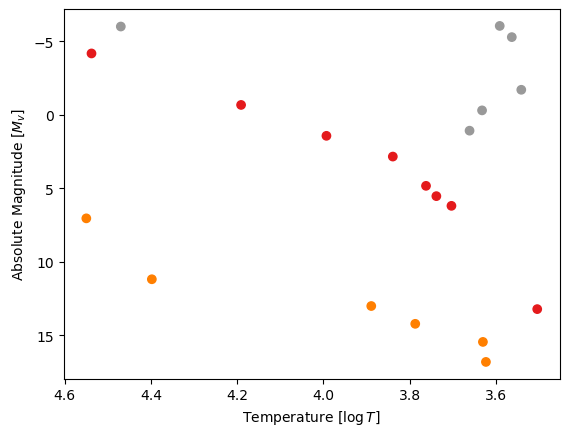

In [3]:
splot = plt.scatter(data['logT'].to_numpy(), data['Abs. Mag.'].to_numpy(), c=data['Y-Type'].to_numpy(), cmap="Set1")
plt.xlabel("Temperature [$\log T$]")
plt.ylabel("Absolute Magnitude [$M_v$]")
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.show()

Next, split the CSV data, and put it into the desired formatable array for use in training.

In [4]:
# Simple data-dependent normalisation funtion
def normalise(x): return (x - np.min(x)) / (np.max(x) - np.min(x))

# Normalise both arrays and zip together
x = np.dstack((normalise(data['Abs. Mag.'].to_numpy()), normalise(data['logT'].to_numpy())))[0]
x

array([[0.47594238, 0.24665392],
       [0.0819141 , 0.98852772],
       [0.23514732, 0.65678776],
       [0.32708726, 0.46749522],
       [0.75395123, 0.85468451],
       [0.88660742, 0.27055449],
       [1.        , 0.11376673],
       [0.00179502, 0.92351816],
       [0.        , 0.083174  ],
       [0.03331728, 0.05640535],
       [0.38881835, 0.32026769],
       [0.50658903, 0.22370937],
       [0.53548444, 0.19024857],
       [0.8428265 , 0.        ],
       [0.8336325 , 0.36806883],
       [0.94045795, 0.12045889],
       [0.57269822, 1.        ],
       [0.31176393, 0.1500956 ],
       [0.19005297, 0.03537285],
       [0.25134626, 0.12237094]])

Then define the y data.

In [5]:
y = np.zeros((20, 3))

for i in range(len(y)):
    y[i][data['Y-Type'][i]-1] = 1

y

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

Now split up and define the testing, training, and validation arrays. Shuffle the training array.

In [6]:
x_train, x_valid, x_test = x[:20], x[:10], x[-10:]
y_train, y_valid, y_test = y[:20], y[:10], y[-10:]
labels_test = data['Name'].to_numpy()[-10:]

print("Training data: {} {}".format(x_train.shape, y_train.shape))
print("Validation data: {} {}".format(x_valid.shape, y_valid.shape))
print("Test data: {} {}".format(x_test.shape, y_test.shape))

Training data: (20, 2) (20, 3)
Validation data: (10, 2) (10, 3)
Test data: (10, 2) (10, 3)


In [7]:
shuffle_index = np.random.permutation(20)
x_train, y_train = x_train[shuffle_index], y_train[shuffle_index]

## Network Definition and Architecture

Let's define the activation functions.

In [8]:
def sigmoid(x):
    '''
    sigmoid(x) = 1 / 1+exp(-x)
    '''
    return 1 / (1+np.exp(-x))

def softmax(x):
    '''
    softmax(x) = exp(x) / ∑exp(x)
    '''
    exps = np.exp(x - np.max(x)) # this makes large exponentials numerically stable
    return exps / np.sum(exps, axis=1)[:,None]

def sigmoid_derivative(x):
    '''
        ∇sigmoid(x) = sigmoid(x)*(1-sigmoid(x))
    '''
    return sigmoid(x) * (1-sigmoid(x))

# let's try sigmoid
def activation(x):
    return sigmoid(x)

def activation_derivative(x):
    return sigmoid_derivative(x)

Then we can define the amount of layers and nodes.

In [9]:
# let's define the number of neurons in each layer first
input_layer = 2
hidden_layer = 3
output_layer = 3

In [10]:
# then we need to initialize the weights and biases in each neuron
w1 = np.zeros([hidden_layer, input_layer])
b1 = np.zeros([hidden_layer,1])
w2 = np.zeros([output_layer, hidden_layer])
b2 = np.zeros([output_layer,1])

w1 += 0.5
w2 += 0.5

Let's create the feed forward algorithim.

In [11]:
# defining how the neuron works
def f_z(x,w,b):
    return (np.matmul(w, x.T)+b).T

def f_y1(x, w1, b1):
    z1 = f_z(x, w1, b1)
    return activation(z1)

def f_y2(y1, w2, b2):
    z2 = f_z(y1, w2, b2)
    return softmax(z2)

def feed_forward(x,w1,b1,w2,b2):
    y1 = f_y1(x, w1, b1)
    y2 = f_y2(y1, w2, b2)
    return y2

And then we can finally visualise the behaviour of this network.

Text(0, 0.5, 'Probability')

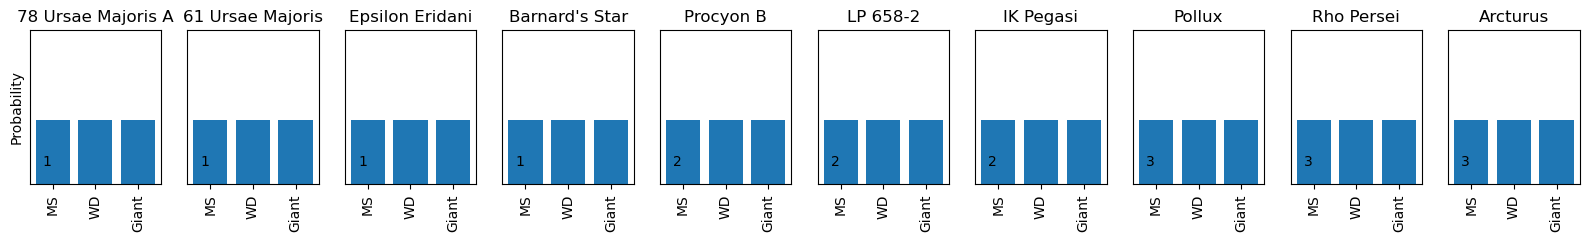

In [12]:
num_col = 10
fig, axes = plt.subplots(1, num_col, figsize=(num_col*2,2))
output = feed_forward(x_test[:20], w1, b1, w2, b2)

for i in range(num_col):
    ax = axes[i]
    ax.set_title(labels_test[i])
    ax.bar(["MS", "WD", "Giant"], output[i])
    ax.tick_params(axis='x', labelrotation=90)
    ax.set_yticks([])
    ax.set_ylim(0,0.8)
    ax.text(0.1,0.1, data['Y-Type'].to_numpy()[i], va='bottom', ha='left', transform=ax.transAxes, color='k')
axes[0].set_ylabel('Probability')

Redefine the weights.

In [13]:
#np.random.seed(2046) # fix your seeds for reproducibility!
#w1 = np.random.randn(hidden_layer, input_layer) / (hidden_layer)**0.5
#w2 = np.random.randn(output_layer, hidden_layer) / (output_layer)**0.5

## Network Training

First, define the cross-entropy loss.

In [14]:
def cross_entropy_loss(y, y2):
    '''
        L(y, ŷ) = −∑ylog(ŷ).
    '''
    return -np.sum(np.multiply(y, np.log(y2)))/len(y)

Then define the calculations of gradient descent.

In [15]:
def gradient_descent(x,y,w1,b1,w2,b2):
    z1 = f_z(x, w1, b1)
    y1 = f_y1(x, w1, b1)
    y2 = f_y2(y1, w2, b2)

    dLdz2 = y2-y

    dLdw2 = np.matmul(dLdz2.T, y1) / len(y1)

    dLdb2 = np.sum(dLdz2, axis=0).reshape([-1,1]) / len(y1)

    dy1dz1 = activation_derivative(z1)

    dLdz1 = np.matmul(dLdz2, w2) * dy1dz1

    dLdw1 = np.matmul(dLdz1.T, x) / len(y1) 
    dLdb1 = np.sum(dLdz1, axis=0).reshape([-1,1]) / len(y1) 

    return {'dLdw1': dLdw1, 'dLdw2': dLdw2, 'dLdb1': dLdb1, 'dLdb2': dLdb2}

Finally, train the model.

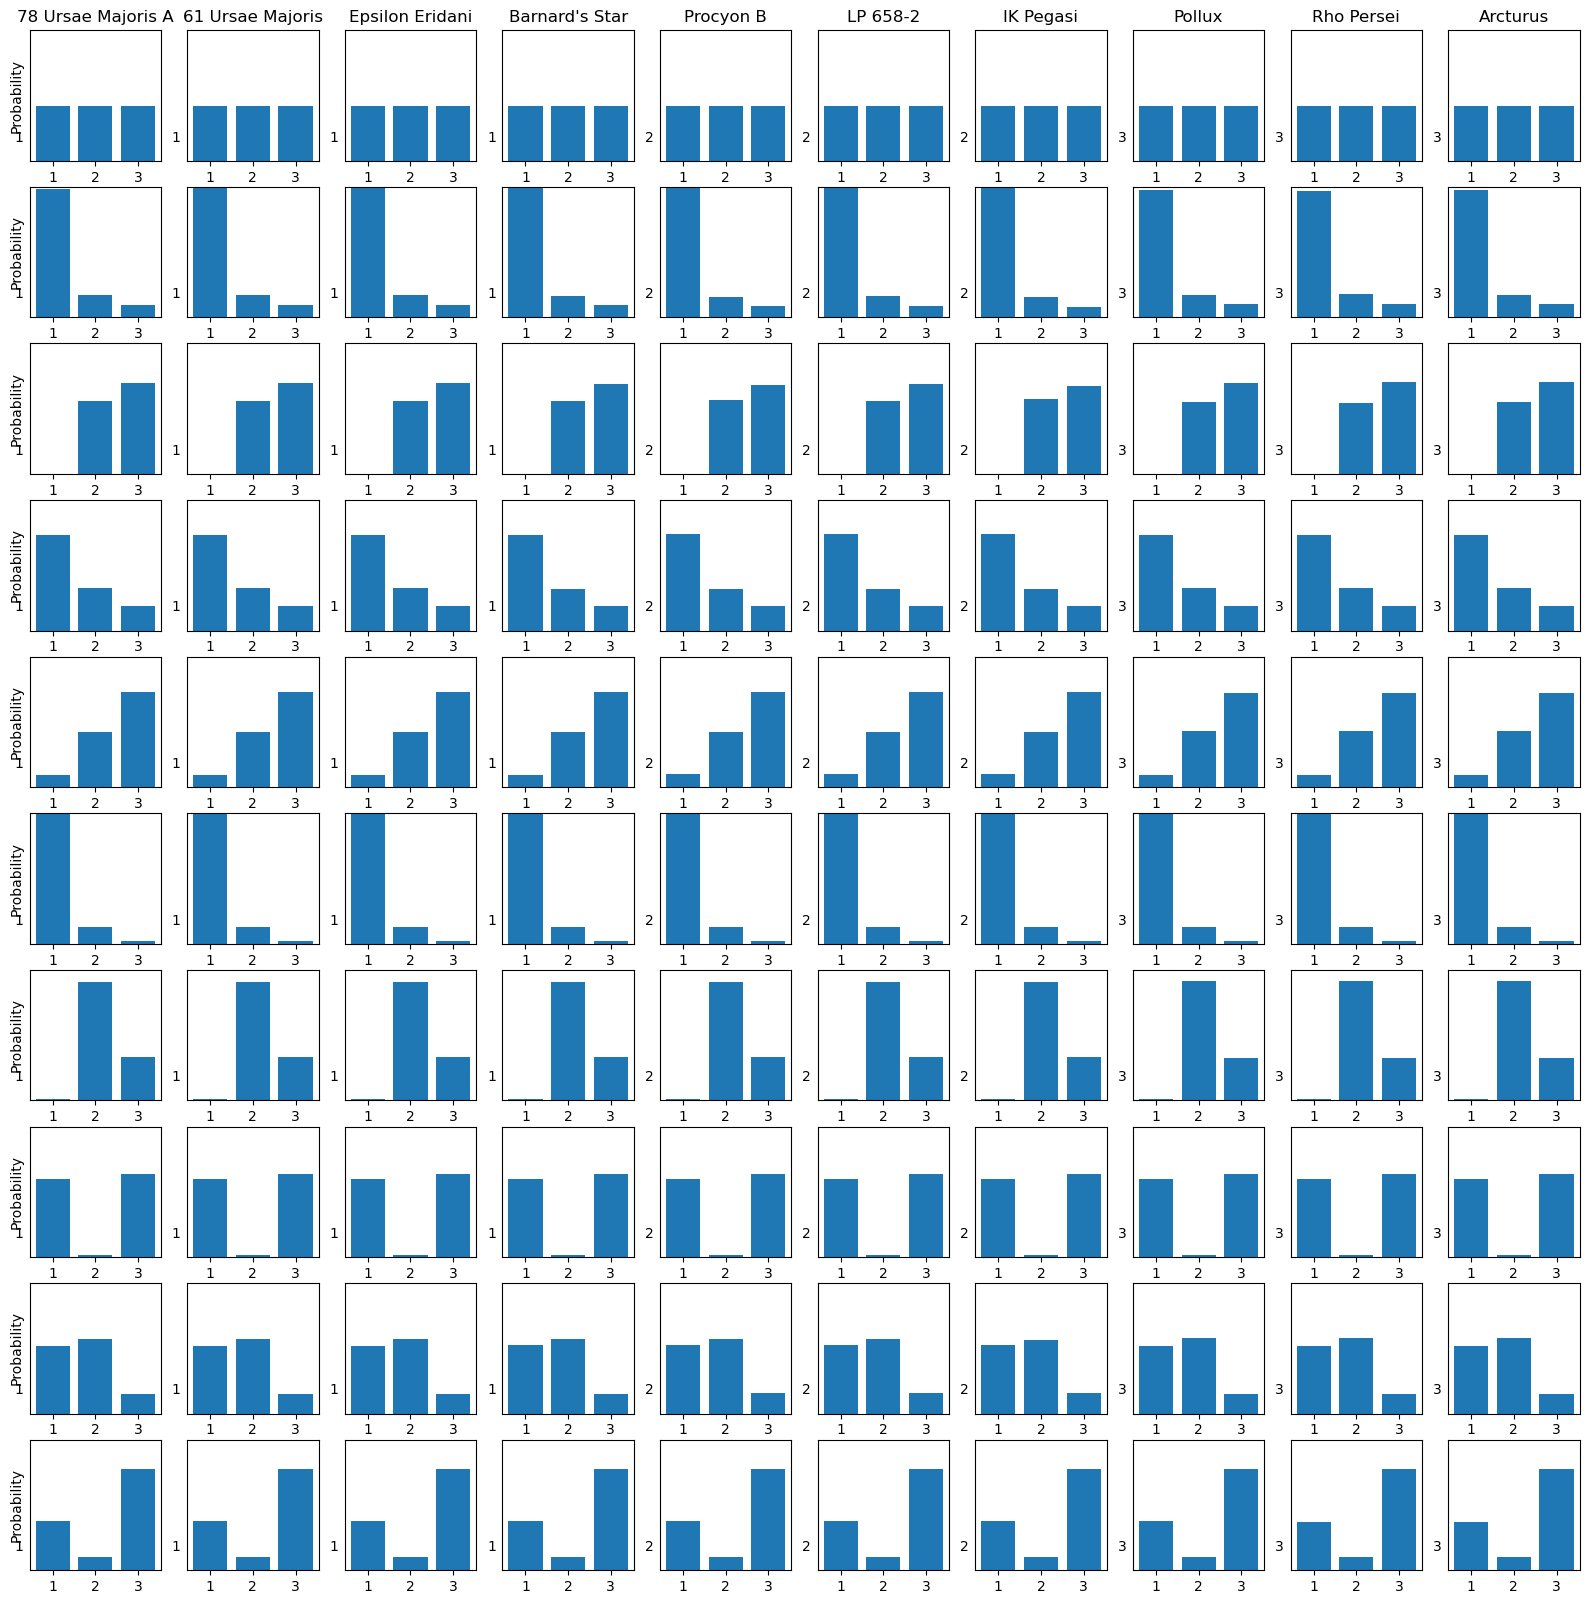

In [16]:
num_col = 10 # visualize 10 images from test set
l_rate = 10 # learning rate
Nepoch = 10  # train for only 10 steps
loss_train = np.zeros(Nepoch) # we will store the loss function for the training set
loss_valid = np.zeros(Nepoch) # and validation

fig, axes = plt.subplots(Nepoch, num_col, figsize=(num_col*2, Nepoch*2))

# Define table of data
results = {'w1': [], 'w2': [], 'b1': [], 'b2': [], 'dLdw1': [], 'dLdw2': [], 'dLdb1': [], 'dLdb2': [], 'output': [], 'loss': []}

# let's show the images on the first row
for i in range(num_col):
    ax = axes[0,i]
    ax.set_title(labels_test[i])
    #ax.set_xticks([])
    #ax.set_yticks([])
    #ax.text(0.1,0.1, labels_test[i], va='bottom', ha='left', transform=ax.transAxes, color='r')

for step in range(Nepoch):
    # calculate the loss using both training and validation sets
    output_train = feed_forward(x_train, w1, b1, w2, b2)
    loss_train[step] = cross_entropy_loss(y_train, output_train)
    output_valid = feed_forward(x_valid, w1, b1, w2, b2)
    loss_valid[step] = cross_entropy_loss(y_valid, output_valid)

    # illustrate the performance using the test set
    output_test = feed_forward(x_test[:20], w1, b1, w2, b2)

    # calculate the gradient and update the weights
    grad = gradient_descent(x_train, y_train, w1, b1, w2, b2)
    w1 = w1 - l_rate * grad['dLdw1']
    b1 = b1 - l_rate * grad['dLdb1']
    w2 = w2 - l_rate * grad['dLdw2']
    b2 = b2 - l_rate * grad['dLdb2']

    # Add the all of the information to the results DF
    rno = 3
    results['w1'].append(np.round(w1, rno))
    results['w2'].append(np.round(w2, rno))
    results['b1'].append(np.round(b1, rno))
    results['b2'].append(np.round(b2, rno))
    results['dLdw1'].append(np.round(grad['dLdw1'], rno))
    results['dLdw2'].append(np.round(grad['dLdw2'], rno))
    results['dLdb1'].append(np.round(grad['dLdb1'], rno))
    results['dLdb2'].append(np.round(grad['dLdb2'], rno))
    results['output'].append(np.round(output_test[0], rno))
    results['loss'].append(np.round(loss_train[step], rno))

    # show the prediction
    for i in range(num_col):
        axp = axes[step,i]
        axp.bar(np.arange(3)+1, output_test[i])
        axp.set_xticks(np.arange(3)+1)
        axp.set_yticks([])
        axp.set_ylim(0,0.8)
        axp.text(0.1,0.1, data['Y-Type'].to_numpy()[i], va='bottom', ha='left', color='k')
    axes[step, 0].set_ylabel('Probability')
    

## Display loss

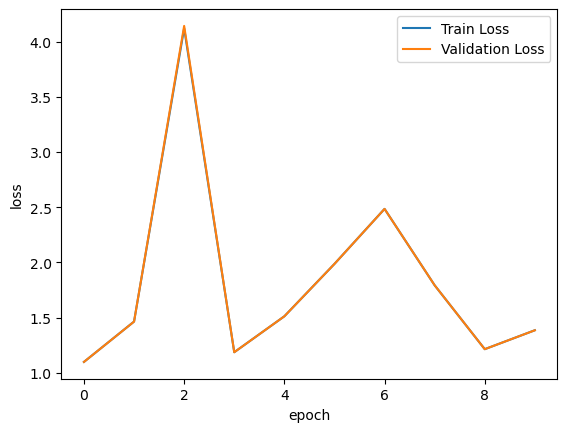

In [17]:
fig, ax = plt.subplots(1,1)
ax.plot(loss_train, label='Train Loss')
ax.plot(loss_valid, label='Validation Loss')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend(loc='upper right')

## Display Tablatures

In [18]:
res = pd.DataFrame(results)
print(res.to_markdown())

|    | w1                | w2                       | b1         | b2         | dLdw1             | dLdw2                    | dLdb1      | dLdb2      | output              |   loss |
|---:|:------------------|:-------------------------|:-----------|:-----------|:------------------|:-------------------------|:-----------|:-----------|:--------------------|-------:|
|  0 | [[0.5 0.5]        | [[0.9   0.9   0.9  ]     | [[0.]      | [[ 0.667]  | [[ 0. -0.]        | [[-0.04  -0.04  -0.04 ]  | [[-0.]     | [[-0.067]  | [0.333 0.333 0.333] |  1.099 |
|    |  [0.5 0.5]        |  [0.465 0.465 0.465]     |  [0.]      |  [-0.333]  |  [ 0. -0.]        |  [ 0.003  0.003  0.003]  |  [-0.]     |  [ 0.033]  |                     |        |
|    |  [0.5 0.5]]       |  [0.134 0.134 0.134]]    |  [0.]]     |  [-0.333]] |  [ 0. -0.]]       |  [ 0.037  0.037  0.037]] |  [-0.]]    |  [ 0.033]] |                     |        |
|  1 | [[0.299 0.335]    | [[-1.462 -1.462 -1.462]  | [[-0.588]  | [[-3.26 ]  | 

|    | w1          | w2                    | b1     | b2         | dLdw1             | dLdw2                    | dLdb1   | dLdb2      | output              |   loss |
|---:|:------------|:----------------------|:-------|:-----------|:------------------|:-------------------------|:--------|:-----------|:--------------------|-------:|
|  0 | [[0.5 0.5]  | [[0.504 0.504 0.504]  | [[0.]  | [[ 0.007]  | [[ 0. -0.]        | [[-0.04  -0.04  -0.04 ]  | [[-0.]  | [[-0.067]  | [0.333 0.333 0.333] |  1.099 |
|    |  [0.5 0.5]  |  [0.5   0.5   0.5  ]  |  [0.]  |  [-0.003]  |  [ 0. -0.]        |  [ 0.003  0.003  0.003]  |  [-0.]  |  [ 0.033]  |                     |        |
|    |  [0.5 0.5]] |  [0.496 0.496 0.496]] |  [0.]] |  [-0.003]] |  [ 0. -0.]]       |  [ 0.037  0.037  0.037]] |  [-0.]] |  [ 0.033]] |                     |        |
|  1 | [[0.5 0.5]  | [[0.508 0.508 0.508]  | [[0.]  | [[ 0.013]  | [[-0. -0.]        | [[-0.037 -0.037 -0.037]  | [[-0.]  | [[-0.062]  | [0.338 0.332 0.33 ] |  1.097 |
|    |  [0.5 0.5]  |  [0.499 0.499 0.499]  |  [0.]  |  [-0.007]  |  [-0. -0.]        |  [ 0.003  0.003  0.003]  |  [-0.]  |  [ 0.032]  |                     |        |
|    |  [0.5 0.5]] |  [0.493 0.493 0.493]] |  [0.]] |  [-0.006]] |  [-0. -0.]]       |  [ 0.035  0.035  0.035]] |  [-0.]] |  [ 0.03 ]] |                     |        |
|  2 | [[0.5 0.5]  | [[0.511 0.511 0.511]  | [[0.]  | [[ 0.019]  | [[-0. -0.]        | [[-0.035 -0.035 -0.035]  | [[-0.]  | [[-0.058]  | [0.342 0.331 0.327] |  1.096 |
|    |  [0.5 0.5]  |  [0.499 0.499 0.499]  |  [0.]  |  [-0.01 ]  |  [-0. -0.]        |  [ 0.002  0.002  0.002]  |  [-0.]  |  [ 0.031]  |                     |        |
|    |  [0.5 0.5]] |  [0.49  0.49  0.49 ]] |  [0.]] |  [-0.009]] |  [-0. -0.]]       |  [ 0.033  0.033  0.033]] |  [-0.]] |  [ 0.027]] |                     |        |
|  3 | [[0.5 0.5]  | [[0.514 0.514 0.514]  | [[0.]  | [[ 0.024]  | [[-0. -0.]        | [[-0.032 -0.032 -0.032]  | [[-0.]  | [[-0.054]  | [0.346 0.33  0.324] |  1.095 |
|    |  [0.5 0.5]  |  [0.499 0.499 0.499]  |  [0.]  |  [-0.013]  |  [-0. -0.]        |  [ 0.001  0.001  0.001]  |  [-0.]  |  [ 0.03 ]  |                     |        |
|    |  [0.5 0.5]] |  [0.487 0.487 0.487]] |  [0.]] |  [-0.011]] |  [-0. -0.]]       |  [ 0.031  0.031  0.031]] |  [-0.]] |  [ 0.024]] |                     |        |
|  4 | [[0.5 0.5]  | [[0.517 0.517 0.517]  | [[0.]  | [[ 0.029]  | [[-0. -0.]        | [[-0.03  -0.03  -0.03 ]  | [[-0.]  | [[-0.05 ]  | [0.35  0.328 0.322] |  1.094 |
|    |  [0.5 0.5]  |  [0.499 0.499 0.499]  |  [0.]  |  [-0.015]  |  [-0. -0.]        |  [ 0.     0.     0.   ]  |  [-0.]  |  [ 0.028]  |                     |        |
|    |  [0.5 0.5]] |  [0.484 0.484 0.484]] |  [0.]] |  [-0.014]] |  [-0. -0.]]       |  [ 0.029  0.029  0.029]] |  [-0.]] |  [ 0.021]] |                     |        |
|  5 | [[0.5 0.5]  | [[0.52  0.52  0.52 ]  | [[0.]  | [[ 0.034]  | [[-0. -0.]        | [[-0.028 -0.028 -0.028]  | [[-0.]  | [[-0.046]  | [0.353 0.327 0.319] |  1.093 |
|    |  [0.5 0.5]  |  [0.499 0.499 0.499]  |  [0.]  |  [-0.018]  |  [-0. -0.]        |  [-0.    -0.    -0.   ]  |  [-0.]  |  [ 0.027]  |                     |        |
|    |  [0.5 0.5]] |  [0.481 0.481 0.481]] |  [0.]] |  [-0.015]] |  [-0. -0.]]       |  [ 0.028  0.028  0.028]] |  [-0.]] |  [ 0.019]] |                     |        |
|  6 | [[0.5 0.5]  | [[0.523 0.523 0.523]  | [[0.]  | [[ 0.038]  | [[-0. -0.]        | [[-0.026 -0.026 -0.026]  | [[-0.]  | [[-0.043]  | [0.357 0.326 0.317] |  1.092 |
|    |  [0.5 0.5]  |  [0.499 0.499 0.499]  |  [0.]  |  [-0.021]  |  [-0. -0.]        |  [-0.001 -0.001 -0.001]  |  [-0.]  |  [ 0.026]  |                     |        |
|    |  [0.5 0.5]] |  [0.478 0.478 0.478]] |  [0.]] |  [-0.017]] |  [-0. -0.]]       |  [ 0.027  0.027  0.027]] |  [-0.]] |  [ 0.017]] |                     |        |
|  7 | [[0.5 0.5]  | [[0.525 0.525 0.525]  | [[0.]  | [[ 0.042]  | [[-0.001 -0.   ]  | [[-0.024 -0.024 -0.024]  | [[-0.]  | [[-0.04 ]  | [0.36  0.325 0.315] |  1.091 |
|    |  [0.5 0.5]  |  [0.499 0.499 0.499]  |  [0.]  |  [-0.023]  |  [-0.001 -0.   ]  |  [-0.001 -0.001 -0.001]  |  [-0.]  |  [ 0.025]  |                     |        |
|    |  [0.5 0.5]] |  [0.476 0.476 0.476]] |  [0.]] |  [-0.019]] |  [-0.001 -0.   ]] |  [ 0.025  0.025  0.025]] |  [-0.]] |  [ 0.014]] |                     |        |
|  8 | [[0.5 0.5]  | [[0.527 0.527 0.527]  | [[0.]  | [[ 0.046]  | [[-0.001 -0.   ]  | [[-0.022 -0.022 -0.022]  | [[-0.]  | [[-0.037]  | [0.363 0.325 0.313] |  1.091 |
|    |  [0.5 0.5]  |  [0.499 0.499 0.499]  |  [0.]  |  [-0.026]  |  [-0.001 -0.   ]  |  [-0.002 -0.002 -0.002]  |  [-0.]  |  [ 0.025]  |                     |        |
|    |  [0.5 0.5]] |  [0.473 0.473 0.473]] |  [0.]] |  [-0.02 ]] |  [-0.001 -0.   ]] |  [ 0.024  0.024  0.024]] |  [-0.]] |  [ 0.013]] |                     |        |
|  9 | [[0.5 0.5]  | [[0.529 0.529 0.529]  | [[0.]  | [[ 0.049]  | [[-0.001 -0.   ]  | [[-0.021 -0.021 -0.021]  | [[-0.]  | [[-0.034]  | [0.365 0.324 0.311] |  1.09  |
|    |  [0.5 0.5]  |  [0.5   0.5   0.5  ]  |  [0.]  |  [-0.028]  |  [-0.001 -0.   ]  |  [-0.002 -0.002 -0.002]  |  [-0.]  |  [ 0.024]  |                     |        |
|    |  [0.5 0.5]] |  [0.471 0.471 0.471]] |  [0.]] |  [-0.021]] |  [-0.001 -0.   ]] |  [ 0.023  0.023  0.023]] |  [-0.]] |  [ 0.011]] |                     |        |


|    | w1                | w2                       | b1         | b2         | dLdw1             | dLdw2                    | dLdb1      | dLdb2      | output              |   loss |
|---:|:------------------|:-------------------------|:-----------|:-----------|:------------------|:-------------------------|:-----------|:-----------|:--------------------|-------:|
|  0 | [[0.5 0.5]        | [[0.9   0.9   0.9  ]     | [[0.]      | [[ 0.667]  | [[ 0. -0.]        | [[-0.04  -0.04  -0.04 ]  | [[-0.]     | [[-0.067]  | [0.333 0.333 0.333] |  1.099 |
|    |  [0.5 0.5]        |  [0.465 0.465 0.465]     |  [0.]      |  [-0.333]  |  [ 0. -0.]        |  [ 0.003  0.003  0.003]  |  [-0.]     |  [ 0.033]  |                     |        |
|    |  [0.5 0.5]]       |  [0.134 0.134 0.134]]    |  [0.]]     |  [-0.333]] |  [ 0. -0.]]       |  [ 0.037  0.037  0.037]] |  [-0.]]    |  [ 0.033]] |                     |        |
|  1 | [[0.299 0.335]    | [[-1.462 -1.462 -1.462]  | [[-0.588]  | [[-3.26 ]  | [[0.02  0.016]    | [[ 0.236  0.236  0.236]  | [[0.059]   | [[ 0.393]  | [0.79  0.135 0.075] |  1.464 |
|    |  [0.299 0.335]    |  [ 1.633  1.633  1.633]  |  [-0.588]  |  [ 1.332]  |  [0.02  0.016]    |  [-0.117 -0.117 -0.117]  |  [0.059]   |  [-0.167]  |                     |        |
|    |  [0.299 0.335]]   |  [ 1.329  1.329  1.329]] |  [-0.588]] |  [ 1.928]] |  [0.02  0.016]]   |  [-0.119 -0.119 -0.119]] |  [0.059]]  |  [-0.226]] |                     |        |
|  2 | [[-0.816 -0.737]  | [[0.21  0.21  0.21 ]     | [[-3.404]  | [[ 0.739]  | [[0.111 0.107]    | [[-0.167 -0.167 -0.167]  | [[0.282]   | [[-0.4  ]  | [0.    0.444 0.555] |  4.121 |
|    |  [-0.816 -0.737]  |  [1.123 1.123 1.123]     |  [-3.404]  |  [-0.132]  |  [0.111 0.107]    |  [ 0.051  0.051  0.051]  |  [0.282]   |  [ 0.146]  |                     |        |
|    |  [-0.816 -0.737]] |  [0.168 0.168 0.168]]    |  [-3.404]] |  [-0.607]] |  [0.111 0.107]]   |  [ 0.116  0.116  0.116]] |  [0.282]]  |  [ 0.253]] |                     |        |
|  3 | [[-0.804 -0.736]  | [[0.173 0.173 0.173]     | [[-3.416]  | [[-1.145]  | [[-0.001 -0.   ]  | [[ 0.004  0.004  0.004]  | [[0.001]   | [[ 0.188]  | [0.588 0.259 0.153] |  1.186 |
|    |  [-0.804 -0.736]  |  [1.112 1.112 1.112]     |  [-3.416]  |  [ 0.28 ]  |  [-0.001 -0.   ]  |  [ 0.001  0.001  0.001]  |  [0.001]   |  [-0.041]  |                     |        |
|    |  [-0.804 -0.736]] |  [0.216 0.216 0.216]]    |  [-3.416]] |  [ 0.865]] |  [-0.001 -0.   ]] |  [-0.005 -0.005 -0.005]] |  [0.001]]  |  [-0.147]] |                     |        |
|  4 | [[-0.799 -0.74 ]  | [[0.228 0.228 0.228]     | [[-3.44]   | [[ 2.077]  | [[-0.001  0.   ]  | [[-0.006 -0.006 -0.006]  | [[0.002]   | [[-0.322]  | [0.078 0.341 0.581] |  1.512 |
|    |  [-0.799 -0.74 ]  |  [1.086 1.086 1.086]     |  [-3.44]   |  [-0.124]  |  [-0.001  0.   ]  |  [ 0.003  0.003  0.003]  |  [0.002]   |  [ 0.04 ]  |                     |        |
|    |  [-0.799 -0.74 ]] |  [0.186 0.186 0.186]]    |  [-3.44]]  |  [-1.953]] |  [-0.001  0.   ]] |  [ 0.003  0.003  0.003]] |  [0.002]]  |  [ 0.282]] |                     |        |
|  5 | [[-0.78  -0.733]  | [[0.141 0.141 0.141]     | [[-3.428]  | [[-2.745]  | [[-0.002 -0.001]  | [[ 0.009  0.009  0.009]  | [[-0.001]  | [[ 0.482]  | [0.882 0.102 0.016] |  1.987 |
|    |  [-0.78  -0.733]  |  [1.104 1.104 1.104]     |  [-3.428]  |  [ 1.854]  |  [-0.002 -0.001]  |  [-0.002 -0.002 -0.002]  |  [-0.001]  |  [-0.198]  |                     |        |
|    |  [-0.78  -0.733]] |  [0.256 0.256 0.256]]    |  [-3.428]] |  [ 0.891]] |  [-0.002 -0.001]] |  [-0.007 -0.007 -0.007]] |  [-0.001]] |  [-0.284]] |                     |        |
|  6 | [[-0.8   -0.756]  | [[0.209 0.209 0.209]     | [[-3.514]  | [[ 1.186]  | [[0.002 0.002]    | [[-0.007 -0.007 -0.007]  | [[0.009]   | [[-0.393]  | [0.007 0.728 0.265] |  2.485 |
|    |  [-0.8   -0.756]  |  [1.009 1.009 1.009]     |  [-3.514]  |  [-2.424]  |  [0.002 0.002]    |  [ 0.009  0.009  0.009]  |  [0.009]   |  [ 0.428]  |                     |        |
|    |  [-0.8   -0.756]] |  [0.282 0.282 0.282]]    |  [-3.514]] |  [ 1.238]] |  [0.002 0.002]]   |  [-0.003 -0.003 -0.003]] |  [0.009]]  |  [-0.035]] |                     |        |
|  7 | [[-0.78  -0.747]  | [[0.193 0.193 0.193]     | [[-3.491]  | [[ 0.391]  | [[-0.002 -0.001]  | [[ 0.002  0.002  0.002]  | [[-0.002]  | [[ 0.079]  | [0.479 0.014 0.507] |  1.793 |
|    |  [-0.78  -0.747]  |  [1.04  1.04  1.04 ]     |  [-3.491]  |  [ 0.441]  |  [-0.002 -0.001]  |  [-0.003 -0.003 -0.003]  |  [-0.002]  |  [-0.287]  |                     |        |
|    |  [-0.78  -0.747]] |  [0.267 0.267 0.267]]    |  [-3.491]] |  [-0.832]] |  [-0.002 -0.001]] |  [ 0.001  0.001  0.001]] |  [-0.002]] |  [ 0.207]] |                     |        |
|  8 | [[-0.781 -0.754]  | [[0.188 0.188 0.188]     | [[-3.523]  | [[ 0.212]  | [[0.    0.001]    | [[ 0.001  0.001  0.001]  | [[0.003]   | [[ 0.018]  | [0.418 0.459 0.123] |  1.214 |
|    |  [-0.781 -0.754]  |  [0.996 0.996 0.996]     |  [-3.523]  |  [-1.145]  |  [0.    0.001]    |  [ 0.004  0.004  0.004]  |  [0.003]   |  [ 0.159]  |                     |        |
|    |  [-0.781 -0.754]] |  [0.316 0.316 0.316]]    |  [-3.523]] |  [ 0.933]] |  [0.    0.001]]   |  [-0.005 -0.005 -0.005]] |  [0.003]]  |  [-0.177]] |                     |        |
|  9 | [[-0.767 -0.749]  | [[0.202 0.202 0.202]     | [[-3.512]  | [[ 1.216]  | [[-0.001 -0.001]  | [[-0.001 -0.001 -0.001]  | [[-0.001]  | [[-0.1 ]   | [0.3  0.08 0.62]    |  1.386 |
|    |  [-0.767 -0.749]  |  [1.016 1.016 1.016]     |  [-3.512]  |  [ 1.053]  |  [-0.001 -0.001]  |  [-0.002 -0.002 -0.002]  |  [-0.001]  |  [-0.22]   |                     |        |
|    |  [-0.767 -0.749]] |  [0.282 0.282 0.282]]    |  [-3.512]] |  [-2.268]] |  [-0.001 -0.001]] |  [ 0.003  0.003  0.003]] |  [-0.001]] |  [ 0.32]]  |                     |        |
